In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

train_data.head()
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [3]:
## Pandas Profiling is used to generate a complete and exhaustive report for the dataset, with many features and customizations in the generated report. 
## This report includes various pieces of information such as dataset statistics, distribution of values, missing values, memory usage, etc., 

import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pp.ProfileReport(train_data, title = 'Pandas Profiling report of train dataset', html = {'style':{'full_width': True}})


/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_19/1620515342.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
pp.ProfileReport(test_data, title = 'Pandas Profiling report of test dataset', html = {'style':{'full_width': True}})


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
## Removing unnecessary data
columns_to_remove = ['PassengerId', 'Name', 'Cabin', 'Ticket']
train_data.drop(columns_to_remove, axis=1, inplace=True)
train_data.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S

In [6]:
# we need passengerid for the final submision
columns_to_remove = ['Name', 'Cabin', 'Ticket']
test_data.drop(columns_to_remove, axis=1, inplace=True)
test_data.head()

PassengerId  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0          892       3    male  34.5      0      0   7.8292        Q
1          893       3  female  47.0      1      0   7.0000        S
2          894       2    male  62.0      0      0   9.6875        Q
3          895       3    male  27.0      0      0   8.6625        S
4          896       3  female  22.0      1      1  12.2875        S

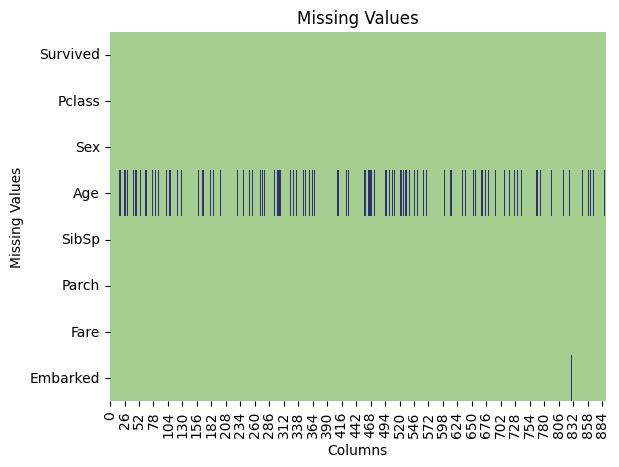

In [7]:
## zooming in on null values
for col in train_data.select_dtypes(include=[object]):
    train_data[col] = train_data[col].replace(r'^\s*$', np.nan, regex=True)
    

ax = plt.axes()
sns.heatmap(train_data.isna().transpose(), cbar=False, ax=ax, cmap='crest')
plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

In [8]:
## handling for null value cases
datasets = [train_data, test_data]

for dataset in datasets:
    median = train_data["Age"].median()
    std = test_data["Age"].std()
    
    is_null = dataset["Age"].isnull().sum()
    
    # compute random numbers between the median, std and is_null
    rand_age = np.random.randint(median - std, median + std, size = is_null)
    
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)
    
train_data["Age"].isnull().sum()

0

In [9]:
top_val = train_data["Embarked"].value_counts().nlargest(1).index.format()[0]
top_val
train_data["Embarked"] = train_data["Embarked"].fillna(top_val)


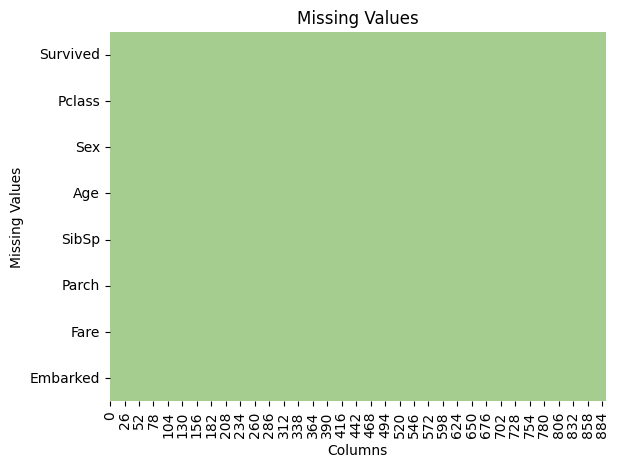

In [10]:
## handling for null value cases
datasets = [train_data, test_data]

for dataset in datasets:
    median = train_data["Age"].median()
    std = test_data["Age"].std()
    
    is_null = dataset["Age"].isnull().sum()
    
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(median - std, median + std, size = is_null)
    
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)
    
train_data["Age"].isnull().sum()
for col in train_data.select_dtypes(include=[object]):
    train_data[col] = train_data[col].replace(r'^\s*$', np.nan, regex=True)
    

ax = plt.axes()
sns.heatmap(train_data.isna().transpose(), cbar=False, ax=ax, cmap='crest')
plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

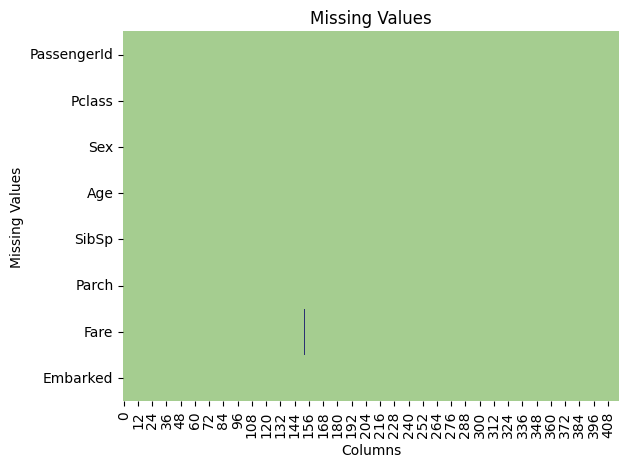

In [11]:
## do the same for test data
for col in test_data.select_dtypes(include=[object]):
    test_data[col] = test_data[col].replace(r'^\s*$', np.nan, regex=True)
    

ax = plt.axes()
sns.heatmap(test_data.isna().transpose(), cbar=False, ax=ax, cmap='crest')
plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

In [12]:
test_data = test_data.fillna(test_data['Fare'].mean())


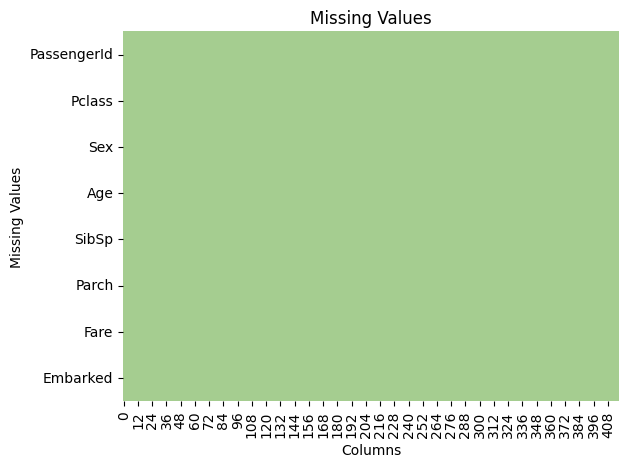

In [13]:
## do the same for test data
for col in test_data.select_dtypes(include=[object]):
    test_data[col] = test_data[col].replace(r'^\s*$', np.nan, regex=True)
    

ax = plt.axes()
sns.heatmap(test_data.isna().transpose(), cbar=False, ax=ax, cmap='crest')
plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_data["Sex"]= le.fit_transform(train_data["Sex"])
print(train_data["Sex"])

train_data["Embarked"]= le.fit_transform(train_data["Embarked"])
print(train_data["Embarked"])

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int64
0      2
1      0
2      2
3      2
4      2
      ..
886    2
887    2
888    2
889    0
890    1
Name: Embarked, Length: 891, dtype: int64


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_data["Sex"]= le.fit_transform(test_data["Sex"])
print(test_data["Sex"])

test_data["Embarked"]= le.fit_transform(test_data["Embarked"])
print(test_data["Embarked"])

0      1
1      0
2      1
3      1
4      0
      ..
413    1
414    0
415    1
416    1
417    1
Name: Sex, Length: 418, dtype: int64
0      1
1      2
2      1
3      2
4      2
      ..
413    2
414    0
415    2
416    2
417    0
Name: Embarked, Length: 418, dtype: int64


In [16]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1)

In [17]:
## let's try feature scaling from sklearn
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)


[[ 0.82737724  0.73769513 -0.52543943 ... -0.47367361 -0.50244517
   0.58595414]
 [-1.56610693 -1.35557354  0.64827798 ... -0.47367361  0.78684529
  -1.9423032 ]
 [ 0.82737724 -1.35557354 -0.23201008 ... -0.47367361 -0.48885426
   0.58595414]
 ...
 [ 0.82737724 -1.35557354 -0.67215411 ...  2.00893337 -0.17626324
   0.58595414]
 [-1.56610693  0.73769513 -0.23201008 ... -0.47367361 -0.04438104
  -1.9423032 ]
 [ 0.82737724  0.73769513  0.20813395 ... -0.47367361 -0.49237783
  -0.67817453]]


In [18]:
print(Y_train)


0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


In [19]:
## Kernel SVM for ML
# Kernel machines are a class of algorithms for pattern analysis, whose best known member is the support-vector machine (SVM). 
# These methods involve using linear classifiers to solve nonlinear problem

from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
classifier.score(X_train, Y_train)
classifier = round(classifier.score(X_train, Y_train) * 100, 2)
classifier

84.06

In [20]:
## lets explore other models

from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
classifier.score(X_train, Y_train)
classifier = round(classifier.score(X_train, Y_train) * 100, 2)
classifier

78.68

In [21]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
classifier.score(X_train, Y_train)
classifier = round(classifier.score(X_train, Y_train) * 100, 2)
classifier

86.08

In [22]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
classifier.score(X_train, Y_train)
classifier = round(classifier.score(X_train, Y_train) * 100, 2)
classifier

96.86

In [23]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
classifier.score(X_train, Y_train)
classifier = round(classifier.score(X_train, Y_train) * 100, 2)
classifier

98.2

In [24]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
classifier.score(X_train, Y_train)
classifier = round(classifier.score(X_train, Y_train) * 100, 2)
classifier

79.46

In [25]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
classifier.score(X_train, Y_train)
classifier = round(classifier.score(X_train, Y_train) * 100, 2)
classifier

96.52

**Decision Tree Classifiers**
* Decision tree algorithms are commonly used with data sets that contain both categorical and numerical variables. 
* These types of data sets are often used in classification problems, where the goal is to predict a categorical outcome based on certain input features

In [26]:
## so far the DecisionTreeClassifier scores the highest but lets see if it is really suitable

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values for tuning
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist, cv=5)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, Y_pred)
print("Test Accuracy with Best Hyperparameters:", accuracy)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
Test Accuracy with Best Hyperparameters: 0.8205741626794258


In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters and their possible values for tuning

# Use RandomizedSearchCV to randomly sample hyperparameters
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist, n_iter=100, cv=5)
random_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model with the best hyperparameters on the test set
best_model = random_search.best_estimator_
accuracy = best_model.score(X_test, Y_pred)
print("Test Accuracy with Best Hyperparameters:", accuracy)

Best Hyperparameters: {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
Test Accuracy with Best Hyperparameters: 0.7990430622009569


In [28]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5,  random_state = 0, splitter='random')
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
classifier.score(X_train, Y_train)
classifier = round(classifier.score(X_train, Y_train) * 100, 2)
classifier

81.59

In [29]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)
